<a href="https://colab.research.google.com/github/avilaJorge/LeastLikelyNN/blob/main/LLNN_pytorch_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Pytorch KNN Code](https://www.kernel-operations.io/keops/_auto_tutorials/knn/plot_knn_mnist.html)

In [ ]:
INIT = False 

In [ ]:
if INIT:
    !pip install pykeops[full] > install.log

In [ ]:
import time

import torch
from matplotlib import pyplot as plt

import pykeops
from pykeops.torch import LazyTensor
if INIT: 
    pykeops.clean_pykeops()          # just in case old build files are still present
    pykeops.test_torch_bindings()    # perform the compilation
import numpy as np
import pandas as pd
import seaborn as sns
import random

use_cuda = torch.cuda.is_available()
tensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
if INIT:
    try:
        from sklearn.datasets import fetch_openml
    except ImportError:
        raise ImportError("This tutorial requires Scikit Learn version >= 0.20.")
    
    mnist = fetch_openml("mnist_784", cache=False)
    
    x = tensor(mnist.data.astype("float32"))
    y = tensor(mnist.target.astype("int64"))

    torch.save(x, 'imgs.pt')
    torch.save(y, 'lbls.pt')
else:
    x = torch.load('imgs.pt')
    y = torch.load('lbls.pt')

In [ ]:
data = torch.hstack((x, y.view(y.shape[0], 1)))

In [ ]:
Ntrain, Ntest = (60000, 10000) if use_cuda else (1000, 100)
x = x/255
D, N = x.shape[1], x.shape[0]
def get_shuffled_data():
    s_data = data[torch.randperm(N)]
    s_x, s_y = s_data[:,:-1], s_data[:, -1]
    x_train, y_train = s_x[:Ntrain, :].contiguous(), s_y[:Ntrain].contiguous()
    x_test, y_test = (
        s_x[Ntrain : Ntrain + Ntest, :].contiguous(),
        s_y[Ntrain : Ntrain + Ntest].contiguous(),
    )
    return (x_train, y_train, x_test, y_test)

In [ ]:
x_train, y_train, x_test, y_test = get_shuffled_data()

In [ ]:
def KNN(x_trn, x_tst, y_trn, y_tst, K, verbose=True):
    
    start = time.time()  # Benchmark:
    
    X_i = LazyTensor(x_tst[:, None, :])  # (10000, 1, 784) test set
    X_j = LazyTensor(x_trn[None, :, :])  # (1, 60000, 784) train set
    D_ij = ((X_i - X_j) ** 2).sum(
        -1
    )  # (10000, 60000) symbolic matrix of squared L2 distances
    
    ind_knn = D_ij.argKmin(K, dim=1)  # Samples <-> Dataset, (N_test, K)
    lab_knn = y_trn[ind_knn]  # (N_test, K) array of integers in [0,9]
    y_knn, _ = lab_knn.mode()  # Compute the most likely label
    
    if use_cuda:
        torch.cuda.synchronize()
    end = time.time()
    
    error = (y_knn != y_tst).float().mean().item()
    runtime = end - start
    
    if verbose: 
        print(
            "{}-NN on the full MNIST dataset: test error = {:.2f}% in {:.2f}s.".format(
                K, error * 100, runtime
            )
        )
    return y_knn, error

In [ ]:
def rand_protos(x_trn, y_trn, M=100):
    idxs = np.array(list(range(x_trn.shape[0])))
    random.shuffle(idxs)
    return x_trn[idxs[:M]], y_trn[idxs[:M]], idxs[M:]

In [ ]:
def LeastLikelyNN(x_trn, y_trn, M=1000, verbose=True):
    
    start = time.time()  # Benchmark:
    X_i = LazyTensor(x_trn[:, None, :])  # (60000, 1, 784) test set
    X_j = LazyTensor(x_trn[None, :, :])  # (1, 60000, 784) train set
    D_ij = ((X_i - X_j) ** 2).sum(
        -1
    )  # (10000, 60000) symbolic matrix of squared L2 distances
    
    ind_knn = D_ij.argKmin(2, dim=1)  # Samples <-> Dataset, (N_test, K)
    lab_knn = y_trn[ind_knn[:,1]]  # (N_test, K) array of integers in [0,9]
    vec_knn = x_trn[ind_knn[:,1]]

    u, cnts = torch.unique(ind_knn[:,1], return_counts=True)
    values, indices = torch.sort(cnts, descending=False)

    lab_knn = lab_knn[indices[:M]]
    vec_knn = vec_knn[indices[:M]]

    if use_cuda:
        torch.cuda.synchronize()
    end = time.time()
    
    runtime = end - start
    
    if verbose: 
        print(
            "{}-NN on the full MNIST dataset: test error = {:.8f}% in {:.2f}s.".format(
                1, 0, runtime
            )
        )
    return vec_knn, lab_knn

The values for const are provided from statistics, and common values used are:

* 1.64 (90%)
* 1.96 (95%)
* 2.33 (98%)
* 2.58 (99%)

Use of these confidence intervals makes some assumptions that you need to ensure you can meet. They are:

Observations in the validation data set were drawn from the domain independently (e.g. they are independent and identically distributed).
At least 30 observations were used to evaluate the model.
This is based on some statistics of sampling theory that takes calculating the error of a classifier as a binomial distribution, that we have sufficient observations to approximate a normal distribution for the binomial distribution, and that via the central limit theorem that the more observations we classify, the closer we will get to the true, but unknown, model skill.

```
error +/- const * sqrt( (error * (1 - error)) / n)
0.02 +/- 1.96 * sqrt( (0.02 * (1 - 0.02)) / 50)
0.02 +/- 1.96 * sqrt(0.0196 / 50)
0.02 +/- 1.96 * 0.0197
0.02 +/- 0.0388
```



In [ ]:
# Confidence interval returned as tuple of (max(min, 0), high)
def compute_confidence_interval(error, ci_const=1.64, n=10000):
    return ci_const * np.sqrt((error * (1 - error)) / n)

In [ ]:
num_expers = 25
K=1
M_vals = [10, 100, 1000, 5000, 10000]
def run_experiments():
    ll_trn_errs = []
    ll_tst_errs = []
    rd_trn_errs = []
    rd_tst_errs = []

    for run in range(num_expers):
        x_trn, y_trn, x_tst, y_tst = get_shuffled_data()
        start = time.time()

        ll_trn_M_errs = []
        ll_tst_M_errs = []
        rd_trn_M_errs = []
        rd_tst_M_errs = []

        for M in M_vals:
           ll_x, ll_y = LeastLikelyNN(x_trn, y_trn, M=M, verbose=False)
           rd_x, rd_y, _ = rand_protos(x_trn, y_trn, M=M) 
           _, ll_tst_err = KNN(ll_x, x_tst, ll_y, y_tst, K=K, verbose=False)
           _, ll_trn_err = KNN(ll_x, x_trn, ll_y, y_trn, K=K, verbose=False)
           ll_trn_M_errs.append(ll_trn_err); ll_tst_M_errs.append(ll_tst_err)

           _, rd_tst_err = KNN(rd_x, x_tst, rd_y, y_tst, K=K, verbose=False)
           _, rd_trn_err = KNN(rd_x, x_trn, rd_y, y_trn, K=K, verbose=False)
           rd_trn_M_errs.append(rd_trn_err); rd_tst_M_errs.append(rd_tst_err)

        ll_trn_errs.append(ll_trn_M_errs)
        ll_tst_errs.append(ll_tst_M_errs)
        rd_trn_errs.append(rd_trn_M_errs)
        rd_tst_errs.append(rd_tst_M_errs)

        end = time.time()
        runtime = end - start

        print(
            "Experiment {} complete in {:.2f}s.".format(
                run, runtime
            )
        )
    return ll_trn_errs, ll_tst_errs, rd_trn_errs, rd_tst_errs


In [ ]:
if INIT:
    ll_trn_errs, ll_tst_errs, rd_trn_errs, rd_tst_errs = run_experiments()
    lle_trn, lle_tst = np.array(ll_trn_errs), np.array(ll_tst_errs)
    np.save('lle_trn.npy', lle_trn); np.save('lle_tst.npy', lle_tst)
    rde_trn, rde_tst = np.array(rd_trn_errs), np.array(rd_tst_errs)
    np.save('rde_trn.npy', rde_trn); np.save('rde_tst.npy', rde_tst)

In [ ]:
lle_trn, lle_tst = np.load('lle_trn.npy'), np.load('lle_tst.npy')

In [ ]:
rde_trn, rde_tst = np.load('rde_trn.npy'), np.load('rde_tst.npy')

In [ ]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

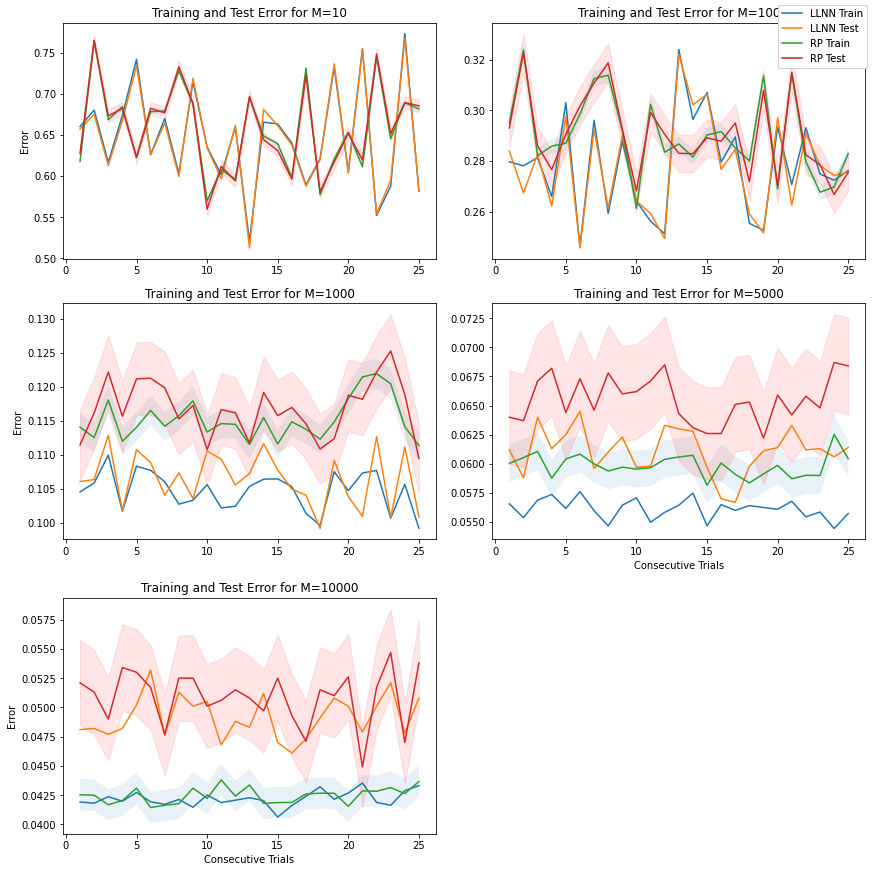

In [ ]:
# Plot results
figsize = (12, 12)
cols = 2
# ci_const = 1.96
# ci_const = 2.58
ci_const = 1.64
rows = len(M_vals) // cols + 1
 
fig1, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
axs = trim_axs(axs, len(M_vals))
x_labels = ['', '', '', 'Consecutive Trials', 'Consecutive Trials']
y_labels = ['Error', '', 'Error', '', 'Error']
x_vals = np.arange(1, 26)

for i, (ax, M) in enumerate(zip(axs, M_vals)):

    ax.plot(x_vals, lle_trn[:, i], label="LLNN Train")
    # ci = compute_confidence_interval(lle_trn[:, i], ci_const=ci_const, n=60000)
    # ax.fill_between(x_vals, lle_trn[:, i] - ci, lle_trn[:, i] + ci, alpha=.1)

    ax.plot(x_vals, lle_tst[:, i], label="LLNN Test")
    # ci = compute_confidence_interval(lle_tst[:, i], ci_const=ci_const)
    # ax.fill_between(x_vals, lle_tst[:, i] - ci, lle_tst[:, i] + ci, alpha=.1)

    ax.plot(x_vals, rde_trn[:, i], label="RP Train")
    ci = compute_confidence_interval(rde_trn[:, i], ci_const=ci_const, n=60000)
    ax.fill_between(x_vals, rde_trn[:, i] - ci, rde_trn[:, i] + ci, alpha=.1)

    ax.plot(x_vals, rde_tst[:, i], label="RP Test")
    ci = compute_confidence_interval(rde_tst[:, i], ci_const=ci_const)
    ax.fill_between(x_vals, rde_tst[:, i] - ci, rde_tst[:, i] + ci, color='r', alpha=.1)

    ax.plot()

    ax.set_xlabel(x_labels[i])
    ax.set_ylabel(y_labels[i])
    ax.set_title("Training and Test Error for M=%d" % M)
    handles, labels = ax.get_legend_handles_labels()
    fig1.legend(handles, labels, loc='upper right')
    fig1.savefig('plots.png', dpi=600)